# Parareal coupling FDTDs of different resolution

In [1]:
# Use Pkg.update() and Pkg.add() to update and add any missing packages
using PyPlot
using IterativeSolvers
using Interpolations

### Define Finite Difference scheme
**Problem setup:**

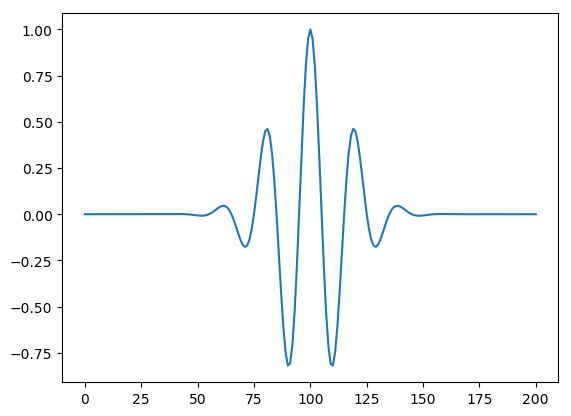

20.0

In [2]:
L = 20.0;
dX = 0.1;
X = collect(0:dX:L);
N = size(X,1);
k = pi;
u = exp.(-0.2*(X-L/2).^2+im*k*(X));
ut = complex(zeros(N));#-im*k*exp.(im*k*(X));#
plot(u)
(2*pi/k)/dX

**Finite difference with velocity verlet update, periodic boundary condition**

In [3]:
function fdtd_wave(u0,ut0,dx,t_final)

    c = 1.0;
    dt = dx/10;    
    N = size(u0,1);
    u = complex(zeros(N));
    ut= complex(zeros(N));
    preu=complex(zeros(N));
    
    u[:] =u0;
    ut[:]=ut0;
    #time = collect(dt:dt:t_final-dt);  # time array
    
    B = spdiagm((ones(N-1),-2*ones(N),ones(N-1)), (-1,0,1))/dx^2;
    B[1,N] = 1.0/dx^2;
    B[N,1] = 1.0/dx^2;
    
    wfd(y,yt) = y + yt*dt + 0.5*dt^2*c^2*B*y;
    
    for t = 1:Int(floor(t_final/dt))  
        preu[:]=u;
        u = wfd(u,ut);
        ut= ut+0.5*dt*c^2*(B*preu+B*u);
    end
    
    return (u,ut)

end

fdtd_wave (generic function with 1 method)

**test fdtd scheme**

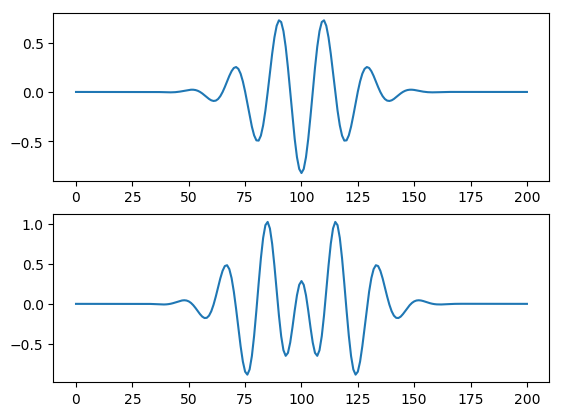

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000025AAE9B0>

In [4]:
uX,utX=fdtd_wave(u,ut,dX,1);
figure()
subplot(2,1,1)
plot((uX))
subplot(2,1,2)
plot((utX))

**test fdtd scheme with finer grid**

In [5]:
### interpolate u
function splineinterp(a,m)
    N=size(a,1);
    periodica=[a[end-2:end-1]; a; a[2:3]];
    itp_u  = interpolate(periodica,BSpline(Cubic(Line())), OnGrid());
    return itp_u[collect(3:1/m:N+2)];   
end

function fourierinterp(a,m)
    N=size(a,1);
    aff = fft(a);
    return ifft([aff[1:Int(floor(N/2))];complex(zeros((m-1)*(N-1)));aff[Int(floor(N/2))+1:end]])*((N-1)*m+1)/N;
end

fourierinterp (generic function with 1 method)

In [6]:
function downsamp(a,m)
    N=size(a,1);
    periodica=[a[end-3:end-1]; a; a[2:4]];
    itp_u = interpolate(periodica,BSpline(Constant()), OnGrid()); 
    return itp_u[collect(4:m:N+3)]; 
end

function fouriersamp(a,m)
    N=size(a,1);
    aff = fft(a);
    st=Int(floor(N/(2*m)))
    en=N-Int(floor(N/(2*m)))
    return ifft([aff[1:st];aff[en:end]])*((N-1)/m+1)/(N);
end

fouriersamp (generic function with 1 method)

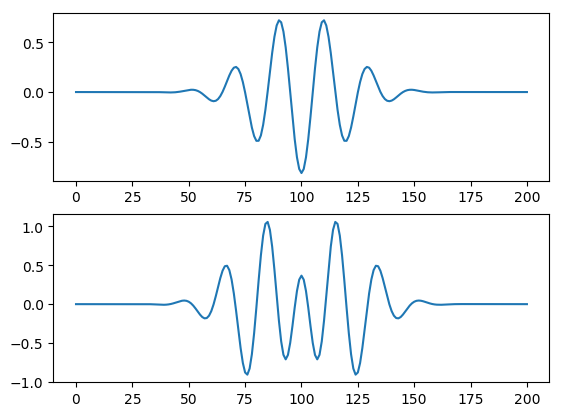

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002CA5F908>

In [7]:
m=10;
dx=dX/m;
x = collect(0:dx:L);

#u4ff =  exp.(im*k*x);
#ut4f = zeros(size(x,1));#-im*k*u4f;
u4f = fourierinterp(u,m);
ut4f = fourierinterp(ut,m);

ub,utb=fdtd_wave(u4f,ut4f,dx,1);

ux  = fouriersamp(ub,m)
utx  = fouriersamp(utb,m)           

figure()
subplot(2,1,1)
plot((ux))
subplot(2,1,2)
plot((utx))

In [ ]:
fuX=fft(uX);
fux=fft(ux);
nom=sum(abs.(fux).^2.*abs.(fuX).^2)/sum(abs.(fux).^2.*abs.(fuX).^4);
#nom=1/sum(abs.(fuX).^2);
conjf=fux.*conj(fuX)*nom;
cfuX=conjf.*fuX;
figure()
plot(fftshift(fux))
plot(fftshift(cfuX-fux))

figure()
plot(imag.(fftshift(fux)))
plot(imag.(fftshift(cfuX-fux)))

println(sum(abs.(cfuX- fux)))
println(sum(abs.(fuX-fux)))

In [ ]:
#plot(fftshift(abs.(fft(u))))
plot(fftshift(imag.(fft(ux).*conj(fft(uX)))))

### Define parareal scheme
**use above fdtd subroutine to do parareal coupling of coarse and fine spatial grid size**

In [14]:
function wave1dparareal(u0,ut0,dX,pimax)
    t_final = 100;
    dT = 1;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,1);
    
    u  = complex(zeros(Nx,Nt));
    ut = complex(zeros(Nx,Nt));
    
    u[:,1]  = u0[:];
    ut[:,1] = ut0[:];
    
    m = 10;
    dx = dX/m;
    
    # initial parareal guess
    for i=2:Nt
        u[:,i],ut[:,i]=fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
    end
    
    # parareal iteration
    finesol = complex(zeros(Nx,Nt));
    finesolt = complex(zeros(Nx,Nt));
    coarsesol= complex(zeros(Nx,Nt));
    coarsesolt= complex(zeros(Nx,Nt));

    cfupdate=complex(zeros(Nx,Nt));
    cftupdate=complex(zeros(Nx,Nt));
    g_ft=complex(zeros(Nx));
    gt_ft=complex(zeros(Nx));
    cgft=complex(ones(Nx));  #zeros for phase-corrector
    cgtft=complex(ones(Nx));
    
    for pri=1:pimax
        
        # PARALLEL COMPUTATION
        for i=2:Nt
            u4f = fourierinterp(u[:,i-1],m);            
            ut4f = fourierinterp(ut[:,i-1],m);
            
            u_fine,ut_fine = fdtd_wave(u4f,ut4f,dx,dT);
            
            finesol[:,i]  = fouriersamp(u_fine,m);         
            finesolt[:,i]  = fouriersamp(ut_fine,m);   
            
            coarsesol[:,i],coarsesolt[:,i] = fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);       
        end
        
        """
        g_ft=complex(zeros(Nx));
        gt_ft=complex(zeros(Nx));       
        
        for i=2:Nt
            ffine = fft(finesol[:,i]);
            ffinet= fft(finesolt[:,i]);
            fcoarse=conj(cgft).*fft(coarsesol[:,i]);
            fcoarset=conj(cgtft).*fft(coarsesolt[:,i]);
            
            #gamm=sum(abs.(fcoarse).^2)/sum(abs.(fcoarse).^4);
            #gammt=sum(abs.(fcoarset).^2)/sum(abs.(fcoarset).^4);
            #gamm=1/maximum(abs.(fcoarse).^2);
            #gammt=1/maximum(abs.(fcoarset).^2);
            #alpha=conj(ffine).*fcoarse*gamm;
            #betaa=conj(ffinet).*fcoarset*gammt;
            #g_ft =g_ft+(alpha-g_ft)/((1-1)*(Nt-1)+i);
            #gt_ft=gt_ft+(betaa-gt_ft)/((1-1)*(Nt-1)+i); 
            
            alpha=exp.(im*angle.(conj(ffine).*fcoarse)).*convert(Array{Int},(abs.(ffine)/maximum(abs.(ffine))).>1e-3);
            betaa=exp.(im*angle.(conj(ffinet).*fcoarset)).*convert(Array{Int},(abs.(ffinet)/maximum(abs.(ffinet))).>1e-3);
            g_ft=g_ft+(alpha-g_ft)/((1-1)*(Nt-1)+i-1);
            gt_ft=gt_ft+(betaa-gt_ft)/((1-1)*(Nt-1)+i-1); 
                
        end
        
        cgft=(g_ft+cgft)/maximum(abs.(g_ft+cgft));
        cgtft=(gt_ft+cgtft)/maximum(abs.(gt_ft+cgtft));
        
        kv=abs.(2*(collect(1:1:Nx)-Nx/2))/Nx;
        cgft=exp.(im*angle.(cgft)).*convert(Array{Int},abs.(cgft.*kv).>0.3);
        cgtft=exp.(im*angle.(cgtft)).*convert(Array{Int},abs.(cgtft.*kv).>0.3);
        """
        
        # SERIAL UPDATE
        for i=2:Nt
            us,uts=fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
            
            ffine = fft(finesol[:,i]);
            ffinet= fft(finesolt[:,i]);
            fcoarse=conj(cgft).*fft(coarsesol[:,i]);
            fcoarset=conj(cgtft).*fft(coarsesolt[:,i]);
            fs=conj(cgft).*fft(us);
            fst=conj(cgtft).*fft(uts);
            
            cfupdate[:,i] = ffine-fcoarse;
            cftupdate[:,i]= ffinet-fcoarset;
            u[:,i] = ifft(fs+cfupdate[:,i]);
            ut[:,i]= ifft(fst+cftupdate[:,i]);
            
        end      
        
    end    
    
    return (u,ut,cgft,finesol,coarsesol)
    
end

wave1dparareal (generic function with 1 method)

**compute initial parareal guess**

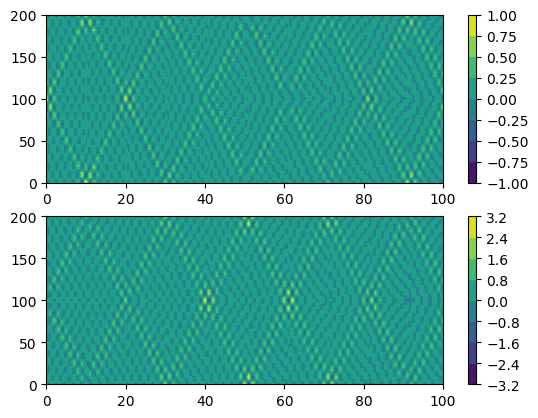

PyObject <matplotlib.colorbar.Colorbar object at 0x000000002D7296A0>

In [9]:
dX=0.1;
u1,ut1=wave1dparareal(u,ut,dX,0);
subplot(2,1,1)
contourf((u1))
colorbar()
subplot(2,1,2)
contourf((ut1))
colorbar()

**compute full fine scale solution**

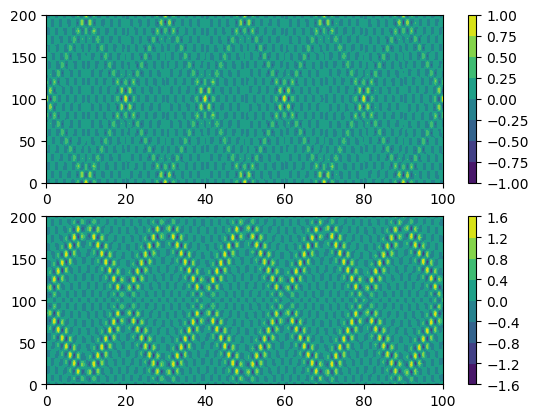

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000030671240>

In [10]:
m=10;
dx=dX/m;

u4f = fourierinterp(u,m);
ut4f = fourierinterp(ut,m);
x = collect(0:dx:L);
#u4f =  exp.(im*k*x);
#ut4f = -im*k*u4f;

ub,utb=wave1dparareal(u4f,ut4f,dx,0);

ubdown = complex(zeros(N,size(ub,2)))
utbdown = complex(zeros(N,size(utb,2)))

for i=1:size(ub,2)   
    ubdown[:,i]  = fouriersamp(ub[:,i],m)
    utbdown[:,i]  = fouriersamp(utb[:,i],m)  
end

subplot(2,1,1)
contourf((ubdown))
colorbar()
subplot(2,1,2)
contourf((utbdown))
colorbar()

In [ ]:
fu1=fft(u1,1);
fub=fft(ubdown,1);
plot(fftshift(abs.(fu1[:,5])))
plot(fftshift(abs.(fub[:,5])))

In [ ]:
plot(u1[:,end])
plot(ubdown[:,end])

**Tune parareal scheme**

In [ ]:
ug,ug2,gft,fs,cs=wave1dparareal(u,ut,dX,2);

In [ ]:
plot(fftshift(abs.(fft(fs[:,4])-(conj(gft).*fft(cs[:,4])))))

In [ ]:
plot(fftshift(abs.(fft(fs[:,50])/maximum(abs.(fft(fs[:,50]))))))

In [ ]:
plot(fftshift(abs.(gft)))
plot(fftshift(abs.(fft(ug[:,20]))./maximum(abs.(fft(ug[:,20])))))
plot(fftshift(abs.(fft(uX))./maximum(abs.(fft(uX)))))

In [ ]:
figure()
subplot(2,1,1);contourf(real(ug));colorbar()
subplot(2,1,2);contourf((abs.(ug-ubdown)));colorbar()

In [ ]:
plot(fftshift(abs.(fft(ug[:,80])-fft(ubdown[:,80]))))

In [ ]:
semilogy(mean(abs.(ug-ubdown),1).')

#### Test and comparison

In [11]:
u2,ut2=wave1dparareal(u,ut,dX,2);
u3,ut3=wave1dparareal(u,ut,dX,5);
u4,ut4=wave1dparareal(u,ut,dX,10);

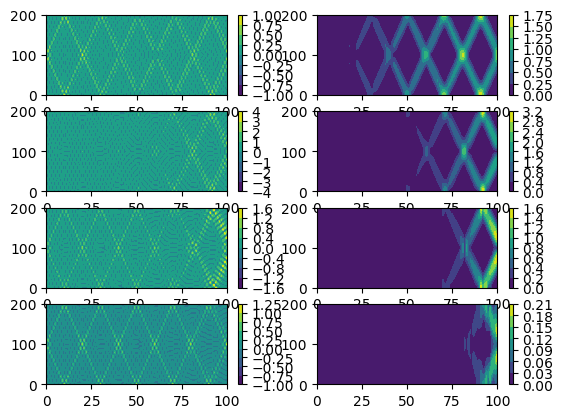

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000349636A0>

In [12]:
figure()
subplot(4,2,1);contourf(real(u1));colorbar()
subplot(4,2,2);contourf(abs.(u1-ubdown));colorbar()
subplot(4,2,3);contourf(real(u2));colorbar()
subplot(4,2,4);contourf(abs.(u2-ubdown));colorbar()
subplot(4,2,5);contourf(real(u3));colorbar()
subplot(4,2,6);contourf(abs.(u3-ubdown));colorbar()
subplot(4,2,7);contourf(real(u4));colorbar()
subplot(4,2,8);contourf(abs.(u4-ubdown));colorbar()

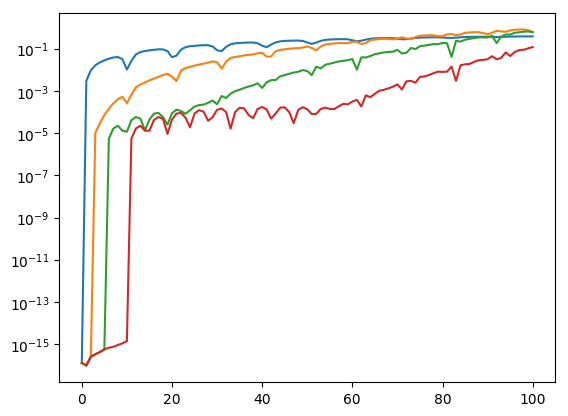

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000034C6C940>

In [13]:
semilogy(mean(abs.(u1-ubdown),1).')
semilogy(mean(abs.(u2-ubdown),1).')
semilogy(mean(abs.(u3-ubdown),1).')
semilogy(mean(abs.(u4-ubdown),1).')

In [15]:
u2s,ut2s=wave1dparareal(u,ut,dX,2);
u3s,ut3s=wave1dparareal(u,ut,dX,5);
u4s,ut4s=wave1dparareal(u,ut,dX,10);

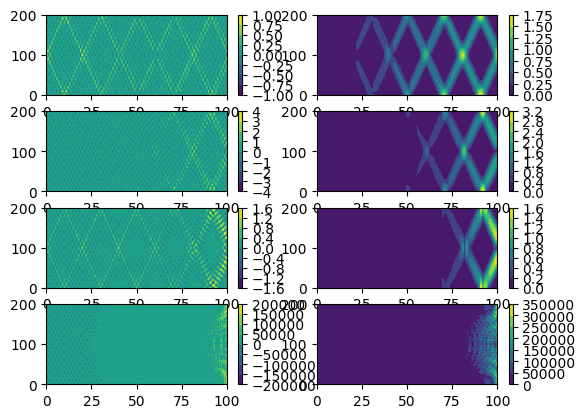

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000375AD898>

In [16]:
figure()
subplot(4,2,1);contourf(real(u1));colorbar()
subplot(4,2,2);contourf(abs.(u1-ubdown));colorbar()
subplot(4,2,3);contourf(real(u2s));colorbar()
subplot(4,2,4);contourf(abs.(u2s-ubdown));colorbar()
subplot(4,2,5);contourf(real(u3s));colorbar()
subplot(4,2,6);contourf(abs.(u3s-ubdown));colorbar()
subplot(4,2,7);contourf(real(u4s));colorbar()
subplot(4,2,8);contourf(abs.(u4s-ubdown));colorbar()

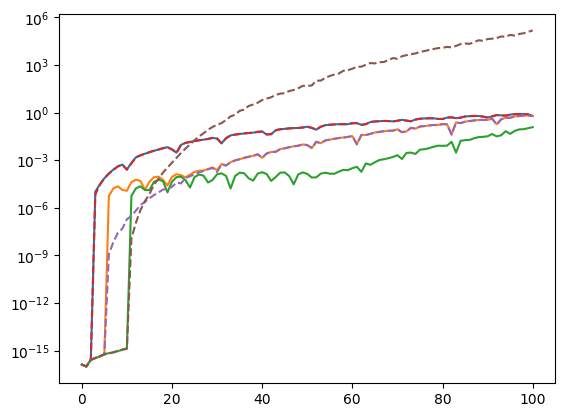

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000377EE908>

In [17]:
semilogy(mean(abs.(u2-ubdown),1).')
semilogy(mean(abs.(u3-ubdown),1).')
semilogy(mean(abs.(u4-ubdown),1).')

semilogy(mean(abs.(u2s-ubdown),1).',linestyle="--")
semilogy(mean(abs.(u3s-ubdown),1).',linestyle="--")
semilogy(mean(abs.(u4s-ubdown),1).',linestyle="--")